In [1]:
# Guides used
# https://www.kaggle.com/jatturat/finding-important-factors-to-survive-titanic]
# https://www.youtube.com/watch?v=COUWKVf6zKY

In [60]:
# Load libraries.
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from xgboost import XGBClassifier

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [3]:
# Load main datasets.
raw_train_dataset = pd.read_csv('data/train.csv', index_col='PassengerId', header=0)
raw_test_dataset = pd.read_csv('data/test.csv', index_col='PassengerId', header=0)

# Describe raw datasets.
print('Train dataset, Columns:\n{0}\n'.format(raw_train_dataset.columns.values))
print('Train dataset, Shape:\n{0}\n'.format(raw_train_dataset.shape))  # (891, 11)
print('Train dataset, Head:\n')
display(raw_train_dataset.head())
print('Train dataset, Describe:\n')
display(raw_train_dataset.describe())

print('Test dataset, Columns:\n{0}\n'.format(raw_test_dataset.columns.values))
print('Test dataset, Shape:\n{0}\n'.format(raw_test_dataset.shape))  # (418, 10)
print('Test dataset, Head:\n')
display(raw_test_dataset.head())
print('Test dataset, Describe:\n')
display(raw_test_dataset.describe())

Train dataset, Columns:
['Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']

Train dataset, Shape:
(891, 11)

Train dataset, Head:



,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Train dataset, Describe:



,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Test dataset, Columns:
['Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare' 'Cabin'
 'Embarked']

Test dataset, Shape:
(418, 10)

Test dataset, Head:



,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Test dataset, Describe:



,Pclass,Age,SibSp,Parch,Fare
count,418.000000,332.000000,418.000000,418.000000,417.000000
mean,2.265550,30.272590,0.447368,0.392344,35.627188
std,0.841838,14.181209,0.896760,0.981429,55.907576
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,27.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.500000
max,3.000000,76.000000,8.000000,9.000000,512.329200


In [4]:
# Explore the data
def plot_continuous_data(dataset_df, feature_name, target_name):
    dataset_copy_df = dataset_df.copy()
    dataset_copy_df['Counts'] = ""  # Trick to skip using an axis (x or y) on splitting violinplot
    fig, [axis0, axis1] = plt.subplots(1, 2, figsize=(10, 5))
    sns.distplot(dataset_copy_df[feature_name],
                 ax=axis0)
    sns.violinplot(data=dataset_copy_df,
                   x=feature_name, y="Counts",
                   hue=target_name, split=True, orient='h', ax=axis1)
    plt.show()

def plot_categorical_data(dataset_df, feature_name, target_name):
    fig, [axis0, axis1] = plt.subplots(1, 2, figsize=(10, 5))
    feature_count_data = dataset_df[feature_name].value_counts()
    piechart_labels = feature_count_data.index.values
    piechart_values = feature_count_data.values
    axis0.pie(x=piechart_values, labels=piechart_labels,
              autopct="%1.3f%%")
    sns.countplot(data=dataset_df,
                  x=feature_name,
                  hue=target_name, ax=axis1)
    plt.show()

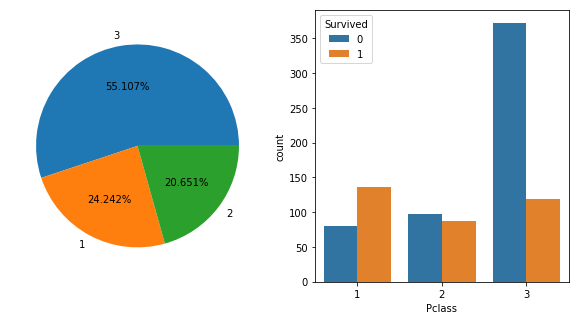

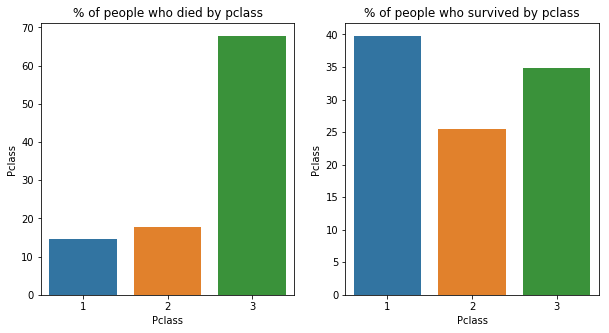

In [5]:
# Ticket class data, column 'Pclass'
# values: 1: high class, 2: middle class, 3: lowest class.

# To note from this chart:
# - class 1 has the most survivors
# - regardless of numbers of people, the higher class is, the higher chance of survival is
# - being in class 3 singificantly reduces the chance of survival

plot_categorical_data(raw_train_dataset, 'Pclass', 'Survived')


# Display percentage of survived/dead passengers by seat class.

# To note from this chart: percentage of people who survived is higher in 3rd class than in the 2nd

fig, [axis0, axis1] = plt.subplots(1, 2, figsize=(10, 5))
passengers_pclass_survived = raw_train_dataset[['Pclass', 'Survived']].copy()

dead_filter, survived_filter = [passengers_pclass_survived['Survived'] == survived_value
                                for survived_value in [0, 1]]

passengers_dead = passengers_pclass_survived[dead_filter]
sns.barplot(data=passengers_dead,
            x="Pclass", y="Pclass",
            estimator=lambda x: len(x) / len(passengers_dead.index) * 100,
            ax=axis0)
axis0.set_title("% of people who died by pclass")
passengers_survived = passengers_pclass_survived[survived_filter]
sns.barplot(data=passengers_survived,
            x="Pclass", y="Pclass",
            estimator=lambda x: len(x) / len(passengers_survived.index) * 100,
            ax=axis1)
axis1.set_title("% of people who survived by pclass")
plt.show()

# Conclusion: Pclass matters for each person to survive or not therefore is an important feature.

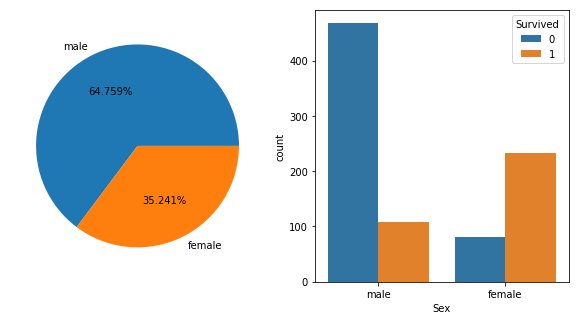

In [6]:
# Sex data, column 'Sex'
# values: 'female', 'male'

# To note from this chart:
# - being a female increases chance for survival and vice-versa for male.
# - males: 2/3 of amount of passengers, females: 1/3

plot_categorical_data(raw_train_dataset, 'Sex', 'Survived')

# Conclusion: 'Sex' is an important feature.

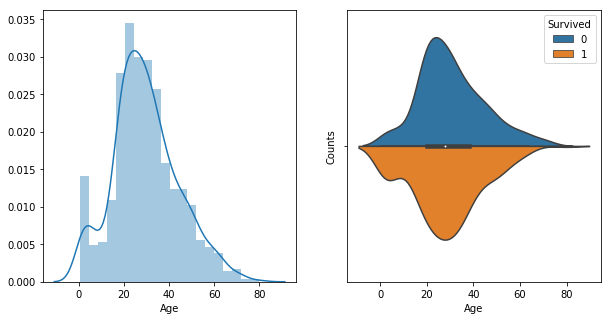

In [7]:
# Age data, column 'Age'
# values: integer, indicates passenger's age in years.

# To note from this chart:
# - chart values distribution shifts to the left side of Age=0.
# - passengers aged 0-5 had pretty good chance for survival
# - significantly more person died aged between 20 and 35
# - people aged 60-80 had lowest chance for survival

age_set_nonan = raw_train_dataset[['Age', 'Survived']].copy().dropna(axis=0)
plot_continuous_data(age_set_nonan, 'Age', 'Survived')

# Conclusion:
# 'Age' is an important feature;
# 'Age' could be divided in different ranges and considered as categorical feature.

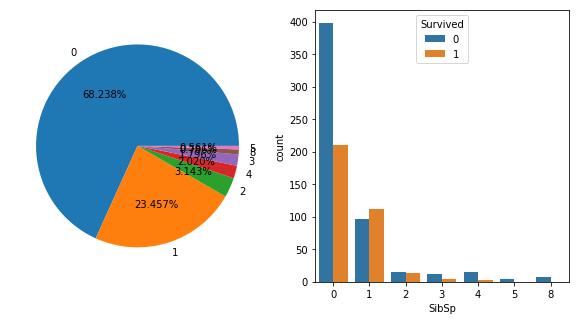

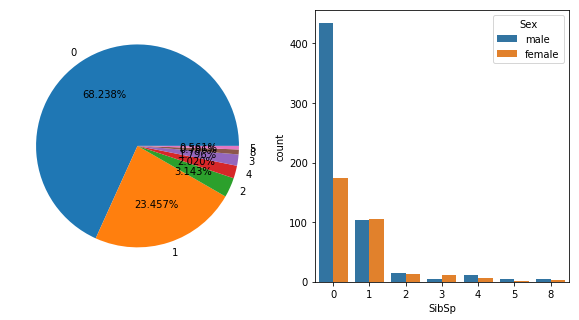

In [8]:
# Number of siblings/spouses aboard the Titanic, column 'SipSp'

# To note from this chart:
# - Only people with 1 SipSp have a bit more survivors compared to the all others
#   People with 2 SipSp - equal chances to survive
#   People with 0 SipSp - 1/2 chance to survive
# - ~33% to survive if 0 SiSp

plot_categorical_data(raw_train_dataset, 'SibSp', 'Survived')

# To note from this chart: 
# - approximately same amount of females/males had 1 child
#   0 children - most of them are men
#   3 children - the only category where females outnumber males

plot_categorical_data(raw_train_dataset, 'SibSp', 'Sex')

# Conclusion:
# 'SipSp' is an important feature to count on

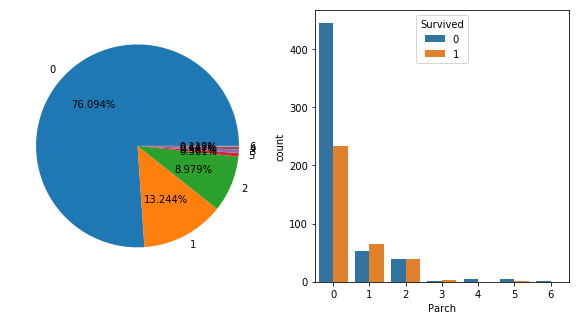

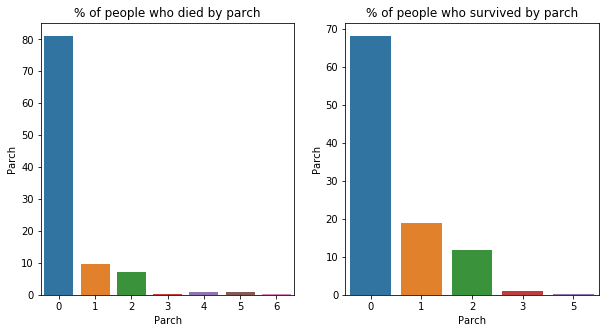

In [9]:
# Number of parents/children aboard the Titanic, column 'Parch'

# To note from this chart:
# - Having 1,2,3 people as parents/children is a 50/50 factor to stay alive
# - ... (todo)

plot_categorical_data(raw_train_dataset, 'Parch', 'Survived')

# To note from this chart:
# - ... (todo)

fig, [axis0, axis1] = plt.subplots(1, 2, figsize=(10, 5))
passengers_parch_survived = raw_train_dataset[['Parch', 'Survived']].copy()
dead_filter, survived_filter = [passengers_parch_survived['Survived'] == survived_value
                                for survived_value in [0, 1]]

passengers_dead = passengers_parch_survived[dead_filter]
sns.barplot(data=passengers_dead,
            x="Parch", y="Parch",
            estimator=lambda x: len(x) / len(passengers_dead.index) * 100,
            ax=axis0)
axis0.set_title("% of people who died by parch")
passengers_survived = passengers_parch_survived[survived_filter]
sns.barplot(data=passengers_survived,
            x="Parch", y="Parch",
            estimator=lambda x: len(x) / len(passengers_survived.index) * 100,
            ax=axis1)
axis1.set_title("% of people who survived by parch")
plt.show()

# Conclusion: 
# - 'Parch' and 'SipSp' are very similar: try to combine them into a single feature.

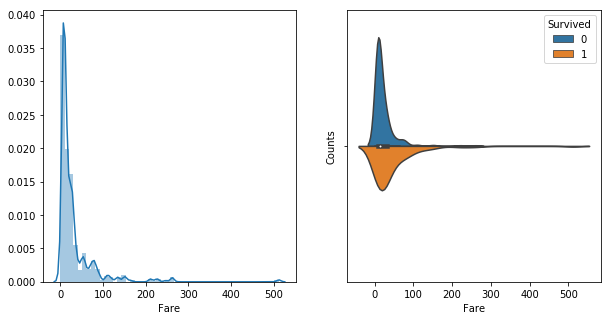

In [10]:
# Passenger fare, column 'Fare'

# To note from this plot:
# - we can try to categorize 'Fare' into several categories: 
#   fare < 10; 10<fare<50; fare>50

passenger_fare_survived = raw_train_dataset[['Fare', 'Survived']].copy().dropna(axis=0)
plot_continuous_data(passenger_fare_survived, 'Fare', 'Survived')


In [11]:
# Passenger cabin, column 'Cabin'

display(raw_train_dataset['Cabin'].value_counts().head(10))
display(raw_test_dataset['Cabin'].value_counts().head(10))

# Idea 1: throw away the column 'Cabin' because of mess in it

# Idea 2: todo

# drop NA data
passengers_cabin = raw_train_dataset[['Cabin']].copy()
passengers_cabin['cabin_data'] = passengers_cabin['Cabin'].isnull().apply(lambda x: not x)

display(passengers_cabin)


B96 B98        4
C23 C25 C27    4
G6             4
E101           3
F33            3
C22 C26        3
F2             3
D              3
E24            2
B35            2
Name: Cabin, dtype: int64

B57 B59 B63 B66    3
B45                2
A34                2
C116               2
E34                2
C6                 2
C31                2
C89                2
C80                2
C55 C57            2
Name: Cabin, dtype: int64

,Cabin,cabin_data
PassengerId,,
1,NaN,False
2,C85,True
3,NaN,False
4,C123,True
5,NaN,False
6,NaN,False
7,E46,True
8,NaN,False
9,NaN,False


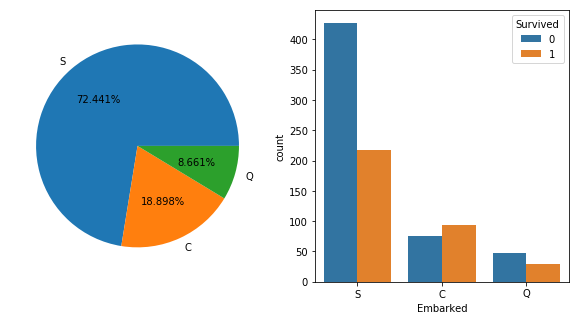

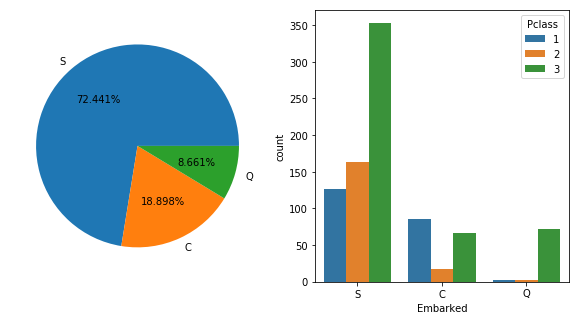

In [12]:
# Port of Embarkation, column 'Embarked'

# To note:
# - City C: only city to survive more than died
plot_categorical_data(raw_train_dataset, 'Embarked', 'Survived')

# To note:
# - City Q: only 3rd class;
# - City C: mostly 1st and 3rd class
# - City S: different, but mostly 3rd class
plot_categorical_data(raw_train_dataset, 'Embarked', 'Pclass')

# Empty values: fill with S, the major port

In [13]:
# Check dataset for null values.

display(raw_train_dataset.isnull().sum())  # age:177, cabin:687, embarked:2
display(raw_test_dataset.isnull().sum())  # age:86, fare:1, cabin:327


Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

,Name,Title
PassengerId,,
1,"Braund, Mr. Owen Harris",Mr
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
3,"Heikkinen, Miss. Laina",Miss


Train dataset "Title" value_counts:


Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Don           1
Capt          1
Lady          1
Ms            1
Sir           1
Mme           1
Countess      1
Jonkheer      1
Name: Title, dtype: int64

Test dataset "Title" value_counts:


Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dona        1
Ms          1
Dr          1
Name: Title, dtype: int64

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


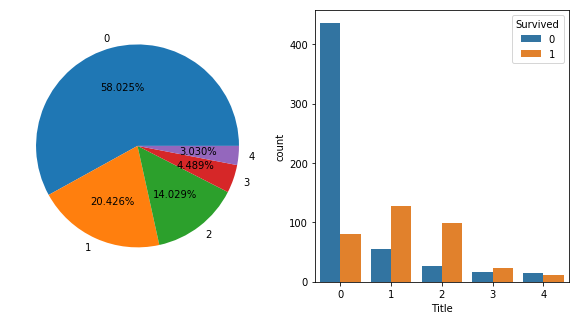

In [14]:
# Work on 'Name' feature in datasets.

train_dataset = raw_train_dataset.copy()
test_dataset = raw_test_dataset.copy()

for dataset in [train_dataset, test_dataset]:
    dataset['Title'] = dataset['Name'].str.extract('([A-Za-z]+)\.', expand=False)

display(train_dataset[['Name', 'Title']].head(3))

print('Train dataset "Title" value_counts:')
display(train_dataset['Title'].value_counts())

print('Test dataset "Title" value_counts:')
display(test_dataset['Title'].value_counts())

# Map 'Title' feature
for dataset in [train_dataset, test_dataset]:
    title_mapping = {
        title_value: 4
        for title_value in dataset['Title'].unique()
    }
    title_mapping['Mr'] = 0
    title_mapping['Miss'] = 1
    title_mapping['Mrs'] = 2
    title_mapping['Master'] = 3
    dataset['Title'] = dataset['Title'].map(title_mapping)

display(train_dataset.head(5))

plot_categorical_data(train_dataset, 'Title', 'Survived')

In [15]:
# Work on 'Sex' feature in datasets.

for dataset in [train_dataset, test_dataset]:
    sex_mapping = {'male': 0, 'female': 1}
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)
    
display(train_dataset.head(10))


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2
3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,2
5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0
6,0,3,"Moran, Mr. James",0,NaN,0,0,330877,8.4583,NaN,Q,0
7,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.8625,E46,S,0
8,0,3,"Palsson, Master. Gosta Leonard",0,2.0,3,1,349909,21.0750,NaN,S,3
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.0,0,2,347742,11.1333,NaN,S,2


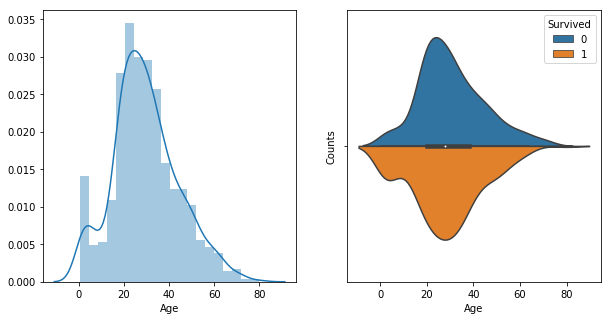

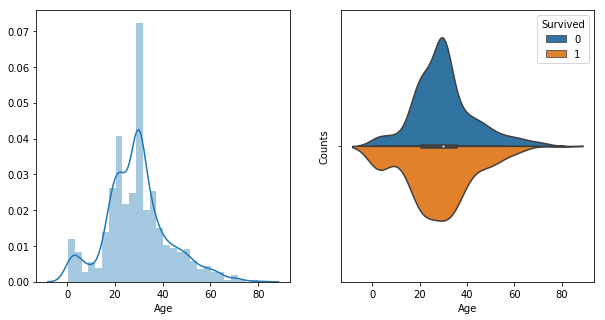

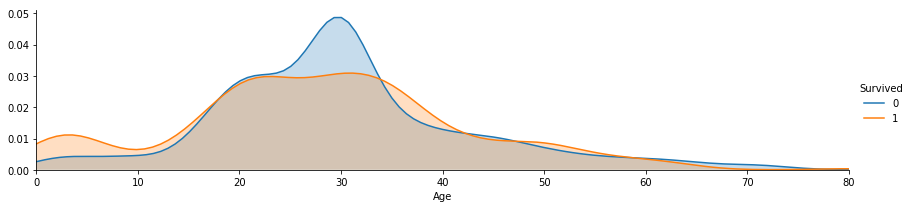

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,1.0,1,0,A/5 21171,7.2500,NaN,S,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,3.0,1,0,PC 17599,71.2833,C85,C,2
3,1,3,"Heikkinen, Miss. Laina",1,2.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2.0,1,0,113803,53.1000,C123,S,2
5,0,3,"Allen, Mr. William Henry",0,2.0,0,0,373450,8.0500,NaN,S,0


Division by age intervals (bins):


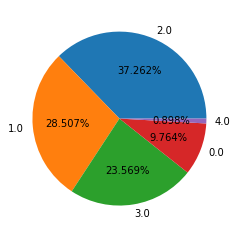

In [16]:
# Work on 'Age' feature in datasets.

# fill up missing Age values with median age by title
for dataset in [train_dataset, test_dataset]:
    dataset['Age'].fillna(
        dataset.groupby('Title')['Age'].transform('median'),
        inplace=True
    )

# Draw chart to view 'Age' and 'Survival' rate again

# Plot, type1
age_set_nonan = raw_train_dataset[['Age', 'Survived']].copy().dropna(axis=0)
plot_continuous_data(age_set_nonan, 'Age', 'Survived')

passengers_age_survived = train_dataset[['Age', 'Survived']].copy()
plot_continuous_data(passengers_age_survived, 'Age', 'Survived')

# Plot, type2
facet = sns.FacetGrid(train_dataset, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, train_dataset['Age'].max()))
facet.add_legend()
plt.show()

# Bin the continuous data 'Age': create a categorical variable
for dataset in [train_dataset, test_dataset]:
    dataset.loc[dataset['Age'] <= 15, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 15) & (dataset['Age'] <= 25), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 25) & (dataset['Age'] <= 35), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 35) & (dataset['Age'] <= 65), 'Age'] = 3
    dataset.loc[dataset['Age'] > 65, 'Age'] = 4
    
display(train_dataset.head(5))

print('Division by age intervals (bins):')
fig, ax = plt.subplots()
feature_count_data = train_dataset['Age'].value_counts()
piechart_labels = feature_count_data.index.values
piechart_values = feature_count_data.values
ax.pie(x=piechart_values, labels=piechart_labels, autopct="%1.3f%%")
plt.show()

In [17]:
# Work on 'Embarked' feature


for dataset in [train_dataset, test_dataset]:
    # Fix missing values with 'S' - the majority of passengers are from there
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    # Map embarked feature values
    embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)
    
display(train_dataset.head(5))

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,1.0,1,0,A/5 21171,7.2500,NaN,0,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,3.0,1,0,PC 17599,71.2833,C85,1,2
3,1,3,"Heikkinen, Miss. Laina",1,2.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2.0,1,0,113803,53.1000,C123,0,2
5,0,3,"Allen, Mr. William Henry",0,2.0,0,0,373450,8.0500,NaN,0,0


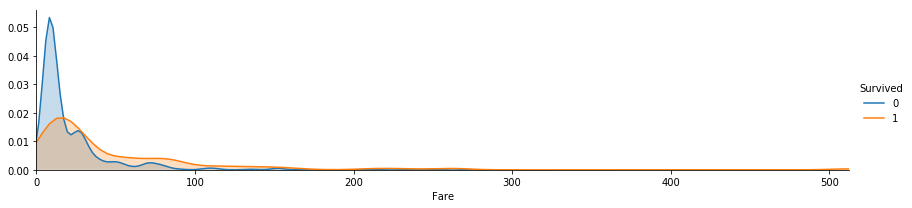

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,1.0,1,0,A/5 21171,0.0,NaN,0,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,3.0,1,0,PC 17599,2.0,C85,1,2
3,1,3,"Heikkinen, Miss. Laina",1,2.0,0,0,STON/O2. 3101282,0.0,NaN,0,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2.0,1,0,113803,2.0,C123,0,2
5,0,3,"Allen, Mr. William Henry",0,2.0,0,0,373450,0.0,NaN,0,0


In [18]:
# Work on 'Fare' feature

for dataset in [train_dataset, test_dataset]:
    # Fix missing values with median value by certain class, not by the whole dataset
    dataset['Fare'].fillna(
        dataset.groupby('Pclass')['Fare'].transform('median'),
        inplace=True
    )
    
# Draw plot to see how exactly divide this continuous data to intervals (bins)
facet = sns.FacetGrid(train_dataset, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Fare', shade=True)
facet.set(xlim=(0, train_dataset['Fare'].max()))
facet.add_legend()
plt.show()

for dataset in [train_dataset, test_dataset]:
    dataset.loc[dataset['Fare'] <= 17, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 17) & (dataset['Fare'] <= 30), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 30) & (dataset['Fare'] <= 95), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 95, 'Fare'] = 3
    
display(train_dataset.head(5))

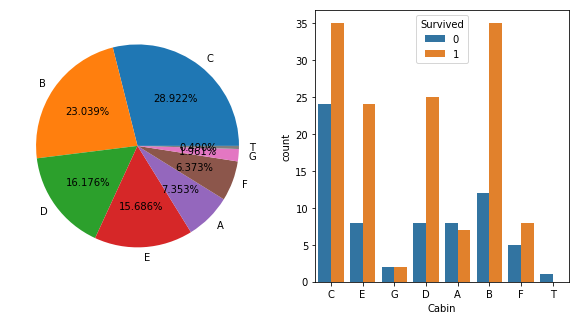

'Class 1'

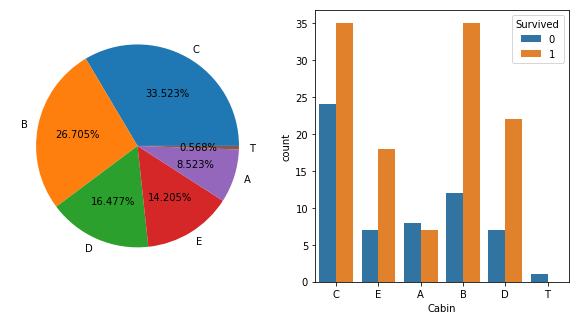

'Class 2'

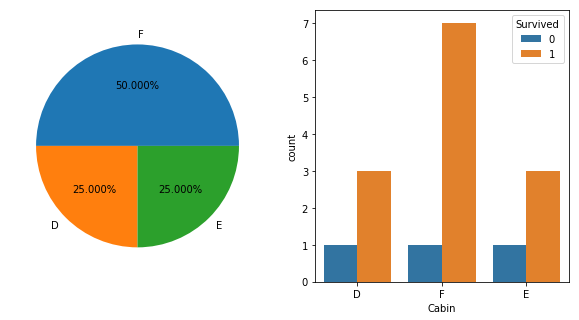

'Class 3'

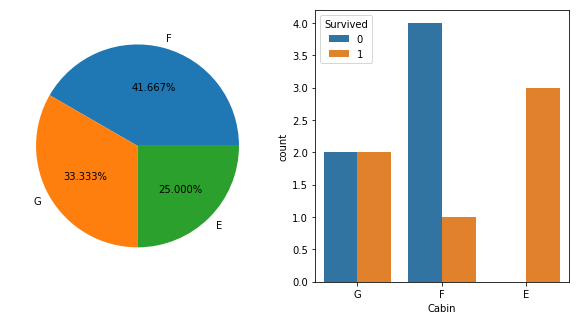

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,HasCabin
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,1.0,1,0,A/5 21171,0.0,2.0,0,0,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,3.0,1,0,PC 17599,2.0,0.8,1,2,1
3,1,3,"Heikkinen, Miss. Laina",1,2.0,0,0,STON/O2. 3101282,0.0,2.0,0,1,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2.0,1,0,113803,2.0,0.8,0,2,1
5,0,3,"Allen, Mr. William Henry",0,2.0,0,0,373450,0.0,2.0,0,0,0


In [19]:
# Work on 'Cabin' feature

# for now, leave only first character
for dataset in [train_dataset, test_dataset]:
    dataset['Cabin'] = dataset['Cabin'].str[:1]
    
plot_categorical_data(train_dataset, 'Cabin', 'Survived')

for key, df_by_pclass in train_dataset.groupby(['Pclass']):
    display('Class {0}'.format(key))
    plot_categorical_data(df_by_pclass, 'Cabin', 'Survived')
    
# Add a simple feature 'HasCabin', it might help
for dataset in [train_dataset, test_dataset]:
    dataset['HasCabin'] = dataset['Cabin'].notnull().astype(int)
    
# Map cabines with scaled bins on ragne [0;3]
for dataset in [train_dataset, test_dataset]:    
    cabin_mapping = {
        'A': 0, 'B': 0.4, 'C': 0.8, 'D': 1.2, 'E': 1.6, 'F': 2, 'G': 2.4, 'T': 2.8
    }
    dataset['Cabin'] = dataset['Cabin'].map(cabin_mapping)
    # Fill NaN values with median for each Pclass
    dataset['Cabin'].fillna(
        dataset.groupby('Pclass')['Cabin'].transform('median'),
        inplace=True
    )
        
# todo cabin: https://www.kaggle.com/ccastleberry/titanic-cabin-features
    
display(train_dataset.head(5))

In [20]:
# Work on ticket numbers, column 'Ticket'

# todo

# https://www.kaggle.com/c/titanic/discussion/11127
# Seems to help find family members or potential nannies.
# Example:
# Jensen, Mr. Hans Peder: TktNum = 350050
# Jensen, Mr. Svend Lauritz: TktNum = 350048
# Jensen, Mr. Niels Peder: TktNum = 350047

# It could mean that tickets sharing the same prefixes could be booked for
# cabins placed together. It could therefore lead to the actual placement
# of the cabins within the ship.

# Also this matters more for females.
# The males have low survival irrespective of their cabin placement.

# I would imagine that the ones containing SOTON were boarded
# at Southampton (Soton is a common abbreviation for Southampton in the UK).

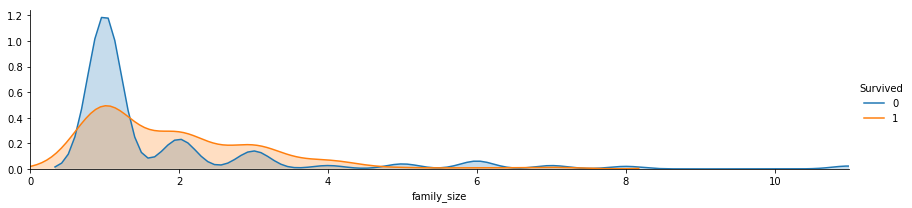

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,HasCabin,family_size
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,1.0,1,0,A/5 21171,0.0,2.0,0,0,0,0.4
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,3.0,1,0,PC 17599,2.0,0.8,1,2,1,0.4
3,1,3,"Heikkinen, Miss. Laina",1,2.0,0,0,STON/O2. 3101282,0.0,2.0,0,1,0,0.0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2.0,1,0,113803,2.0,0.8,0,2,1,0.4
5,0,3,"Allen, Mr. William Henry",0,2.0,0,0,373450,0.0,2.0,0,0,0,0.0


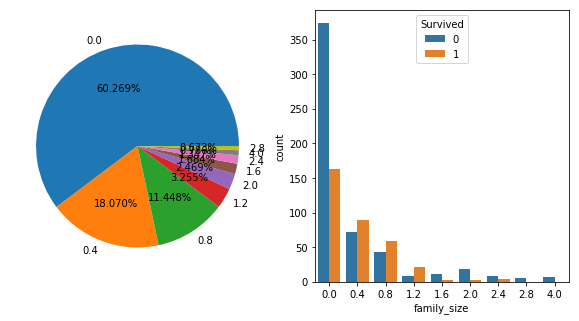

In [21]:
# Work on 'family_size': combine 'SibSp' and 'Parch' similar features
for dataset in [train_dataset, test_dataset]:
    dataset['family_size'] = dataset['SibSp'] + dataset['Parch'] + 1
    
facet = sns.FacetGrid(train_dataset, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'family_size', shade=True)
facet.set(xlim=(0, train_dataset['family_size'].max()))
facet.add_legend()
plt.show()

for dataset in [train_dataset, test_dataset]:
    familysize_mapping = {
        1:0, 2:.4, 3:.8,
        4:1.2, 5:1.6,
        6:2, 7:2.4, 8:2.8,
        9:3.2, 10:3.6, 11:4        
    }
    dataset['family_size'] = dataset['family_size'].map(familysize_mapping)
    
display(train_dataset.head(5))

# To note: similar to 'SibSp' and 'Parch' plots
plot_categorical_data(train_dataset, 'family_size', 'Survived')

In [22]:
# Drop cols

for dataset in [train_dataset, test_dataset]:
    # Drop unnecessary features
    features_to_drop = ['Ticket', 'SibSp', 'Parch', 'Name']
    dataset.drop(features_to_drop, axis=1, inplace=True)
    # Final check of the datasets
    display(dataset.head(5))

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,HasCabin,family_size
PassengerId,,,,,,,,,,
1,0,3,0,1.0,0.0,2.0,0,0,0,0.4
2,1,1,1,3.0,2.0,0.8,1,2,1,0.4
3,1,3,1,2.0,0.0,2.0,0,1,0,0.0
4,1,1,1,2.0,2.0,0.8,0,2,1,0.4
5,0,3,0,2.0,0.0,2.0,0,0,0,0.0


,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,HasCabin,family_size
PassengerId,,,,,,,,,
892,3,0,2.0,0.0,2.0,2,0,0,0.0
893,3,1,3.0,0.0,2.0,0,2,0,0.4
894,2,0,3.0,0.0,2.0,2,0,0,0.0
895,3,0,2.0,0.0,2.0,0,0,0,0.0
896,3,1,1.0,0.0,2.0,0,2,0,0.8


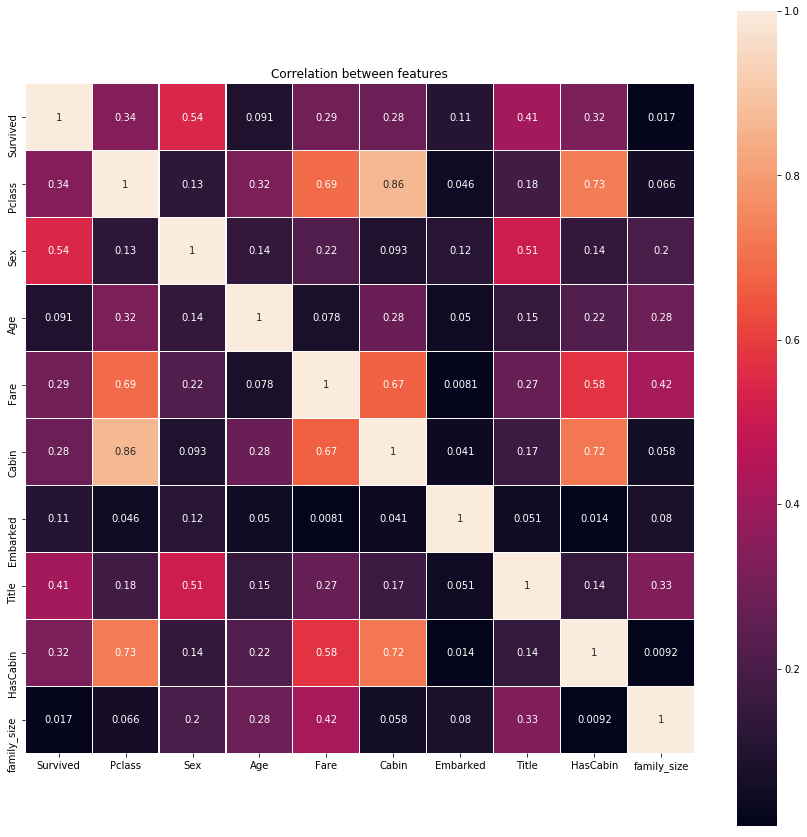

In [23]:
# Check for correlations

# 0.34 - Pclass
# 0.54 - Sex
# 0.41 - Title
# 0.32 - HasCabin

plt.figure(figsize=(15, 15))
plt.title('Correlation between features')
sns.heatmap(
    train_dataset.corr().abs(),
    annot=True, linecolor='white', square=True, vmax=1.0, linewidths=0.1
)
plt.show()

In [24]:
# Prepare data for modelling

X_train = train_dataset.drop('Survived', axis=1)
Y_train = train_dataset['Survived']

print(X_train.shape, Y_train.shape)

(891, 9) (891,)


In [25]:
display(X_train.isnull().sum())
display(Y_train.isnull().sum())

Pclass         0
Sex            0
Age            0
Fare           0
Cabin          0
Embarked       0
Title          0
HasCabin       0
family_size    0
dtype: int64

0

In [26]:
# Prepare for cross-validation 

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

def try_classifier(clf):
    scoring = 'accuracy'
    score = cross_val_score(clf,
                            X_train, Y_train,
                            cv=k_fold, n_jobs=-1, scoring=scoring)
    print(score)
    print(np.mean(score) * 100, 2)

In [27]:
# Check feature importances
rforest_checker = RandomForestClassifier(random_state=0, n_estimators=100)
rforest_checker.fit(X_train, Y_train)
importances_df = pd.DataFrame(rforest_checker.feature_importances_,
                              columns=['feature_importance'],
                              index=X_train.columns)
importances_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
display(importances_df)

# Title: 0.245
# Sex: 0.199
# family_size: 0.131
# Cabin: 0.103

,feature_importance
Title,0.245140
Sex,0.198682
family_size,0.130600
Cabin,0.103836
Age,0.091108
Fare,0.076010
Pclass,0.062412
Embarked,0.053970
HasCabin,0.038241


In [51]:
# Create classifiers
classifiers = {
    'knn_clf': KNeighborsClassifier(n_neighbors=100),
    'logreg_clf': LogisticRegression(solver='lbfgs'),
    'gnb_clf': GaussianNB(),
    'dtc_clf': DecisionTreeClassifier(),
    'rfc_clf': RandomForestClassifier(n_estimators=100),
    'svc_clf': SVC()
}
for clf_name, clf_obj in classifiers.items():
    print('clf_name: {0}'.format(clf_name))
    try_classifier(clf_obj)
    print('\n')

clf_name: knn_clf
[0.77777778 0.79775281 0.75280899 0.69662921 0.7752809  0.83146067
 0.7752809  0.76404494 0.74157303 0.78651685]
76.99126092384519 2


clf_name: logreg_clf
[0.8        0.78651685 0.80898876 0.7752809  0.78651685 0.80898876
 0.82022472 0.83146067 0.82022472 0.85393258]
80.92134831460675 2


clf_name: gnb_clf
[0.83333333 0.7752809  0.73033708 0.73033708 0.74157303 0.80898876
 0.73033708 0.76404494 0.85393258 0.82022472]
77.88389513108615 2


clf_name: dtc_clf
[0.77777778 0.8988764  0.76404494 0.76404494 0.83146067 0.79775281
 0.84269663 0.76404494 0.74157303 0.7752809 ]
79.57553058676655 2


clf_name: rfc_clf
[0.83333333 0.87640449 0.79775281 0.79775281 0.83146067 0.84269663
 0.83146067 0.78651685 0.75280899 0.82022472]
81.70411985018727 2


clf_name: svc_clf
[0.84444444 0.80898876 0.82022472 0.82022472 0.84269663 0.82022472
 0.84269663 0.85393258 0.83146067 0.85393258]
83.38826466916353 2




In [29]:
# # Try removing features with low importance: try to reduce noise
X_train_2 = train_dataset.drop(['Survived', 'HasCabin', 'Embarked'], axis=1)

def try_classifier_2(clf):
    scoring = 'accuracy'
    score = cross_val_score(clf,
                            X_train_2, Y_train,
                            cv=k_fold, n_jobs=-1, scoring=scoring)
    print(score)
    print(np.mean(score) * 100, 2)

for clf_name, clf_obj in classifiers.items():
    print('clf_name: {0}'.format(clf_name))
    try_classifier_2(clf_obj)
    print('\n')

clf_name: knn_clf
[0.75555556 0.80898876 0.7752809  0.74157303 0.74157303 0.83146067
 0.82022472 0.79775281 0.80898876 0.82022472]
79.01622971285892 2


clf_name: gnb_clf
[0.83333333 0.74157303 0.74157303 0.75280899 0.70786517 0.79775281
 0.74157303 0.79775281 0.85393258 0.82022472]
77.88389513108615 2


clf_name: dtc_clf
[0.8        0.86516854 0.82022472 0.79775281 0.82022472 0.7752809
 0.82022472 0.78651685 0.74157303 0.83146067]
80.58426966292134 2


clf_name: rfc_clf
[0.83333333 0.84269663 0.82022472 0.78651685 0.85393258 0.7752809
 0.83146067 0.79775281 0.78651685 0.86516854]
81.92883895131085 2


clf_name: svc_clf
[0.84444444 0.80898876 0.82022472 0.82022472 0.84269663 0.80898876
 0.83146067 0.85393258 0.83146067 0.83146067]
82.93882646691635 2




In [30]:
# Linear models
logreg_clf = LogisticRegression(solver='lbfgs')

logreg_clf.fit(X_train, Y_train)
logreg_cvs = cross_val_score(estimator=logreg_clf,
                             X=X_train, y=Y_train,
                             cv=10)
print(logreg_cvs)
print(logreg_cvs.mean())  # mean of accuracy score
print(logreg_cvs.std())  # Standard deviation = differences of the accuracy score in each cross validations.
                         # the less = less variance = the better

# Try less parameters
print('\n')
logreg_clf.fit(X_train_2, Y_train)
logreg_cvs = cross_val_score(estimator=logreg_clf, X=X_train_2, y=Y_train, cv=10)
print(logreg_cvs)
print(logreg_cvs.mean())
print(logreg_cvs.std())

# Try scaling data
print('\n')
minmax_scaler = preprocessing.MinMaxScaler()
X_train_copy = X_train.copy()
for col in X_train_copy:
    X_train_copy[col] = X_train_copy[col].astype('float')
X_train_minmax = minmax_scaler.fit_transform(X_train_copy)
logreg_clf.fit(X_train_minmax, Y_train)
logreg_cvs = cross_val_score(estimator=logreg_clf, X=X_train_minmax, y=Y_train, cv=10)
print(logreg_cvs)
print(logreg_cvs.mean())
print(logreg_cvs.std())

[0.82222222 0.81111111 0.7752809  0.87640449 0.84269663 0.79775281
 0.83146067 0.83146067 0.80898876 0.80681818]
0.820419645897174
0.026136623385488653


[0.8        0.82222222 0.7752809  0.87640449 0.83146067 0.78651685
 0.82022472 0.80898876 0.82022472 0.79545455]
0.8136777891272272
0.026763399515686254


[0.81111111 0.81111111 0.7752809  0.87640449 0.83146067 0.79775281
 0.84269663 0.78651685 0.80898876 0.80681818]
0.8148141527635909
0.027618670901495692


In [43]:
# Hyper parameters tuning by GridSearchCV: logistic regression
logreg_params = [
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [0.01, 0.1, 1, 10, 100]},
    {'penalty': ['l2'], 'solver': ['lbfgs', 'sag', 'newton-cg'], 'C': [0.01, 0.1, 1, 10, 100]}
]
logreg_grid = GridSearchCV(
    estimator=LogisticRegression(random_state=0),
    param_grid=logreg_params,
    scoring='accuracy',
    cv=10,
    iid=True,
    n_jobs=-1
)
logreg_grid = logreg_grid.fit(X_train, Y_train)
logreg_best_accuracy = logreg_grid.best_score_
logreg_best_params = logreg_grid.best_params_

print(logreg_best_accuracy)
print(logreg_best_params)


0.8204264870931538
{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


In [46]:
# Hyper parameters tuning by GridSearchCV: Kernel SVM

# Because we don't have continuous feature, we need to normalize the data.
X_train_norm = X_train.copy()
X_train_norm = X_train_norm.apply(
    lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x))
)

params_ksvm = [
    {'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
    {'C': [0.1, 1, 10, 100], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5]},
    {'C': [0.1, 1, 10, 100], 'kernel': ['poly'], 'degree': [1, 2, 3], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5]}
]
grid_ksvm = GridSearchCV(
    estimator = SVC(random_state=0),
    param_grid = params_ksvm,
    scoring = 'accuracy',
    cv = 10,
    n_jobs=-1,
    iid=True
)
grid_ksvm = grid_ksvm.fit(X_train_norm, Y_train)
best_acc_ksvm = grid_ksvm.best_score_
best_params_ksvm = grid_ksvm.best_params_

print(best_acc_ksvm)
print(best_params_ksvm)

0.8372615039281706
{'C': 100, 'degree': 3, 'gamma': 0.3, 'kernel': 'poly'}


In [48]:
# Hyper parameters tuning by GridSearchCV: Decision Tree
params_dtree = [{
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'log2']}
]
grid_dtree = GridSearchCV(
    estimator=DecisionTreeClassifier(criterion = 'gini', random_state=0),
    param_grid=params_dtree,
    scoring='accuracy',
    cv=10,
    iid=True,
    n_jobs=-1
)
grid_dtree = grid_dtree.fit(X_train, Y_train)
best_acc_dtree = grid_dtree.best_score_
best_params_dtree = grid_dtree.best_params_

print(best_acc_dtree)
print(best_params_dtree)

0.8271604938271605
{'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 20}


In [50]:
# Hyper parameters tuning by GridSearchCV: Random Forest
params_rforest = [{
    'n_estimators': [10, 100, 200, 300, 500, 800],
    'max_depth': [5, 7, 10, 15, 20],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'log2']
}]
grid_rforest = GridSearchCV(
    estimator=RandomForestClassifier(criterion='gini', random_state=0, n_jobs=-1),
    param_grid = params_rforest,
    scoring = 'accuracy',
    cv = 10,
    n_jobs=-1,
    iid=10
)
grid_rforest = grid_rforest.fit(X_train, Y_train)
best_acc_rforest = grid_rforest.best_score_
best_params_rforest = grid_rforest.best_params_

print(best_acc_rforest)
print(best_params_rforest)

0.8406285072951739
{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}


In [55]:
# Compare grid search scores

grid_score_dict = {
    'Best Score': [logreg_best_accuracy, best_acc_ksvm, best_acc_dtree, best_acc_rforest],
    'Optimized Parameters': [logreg_best_params, best_params_ksvm, best_params_dtree, best_params_rforest],
}
grid_score_df = pd.DataFrame(
    grid_score_dict,
    index=['Logistic Regression','Kernel SVM','Decision Tree','Random Forest']
)

display(grid_score_df)

,Best Score,Optimized Parameters
Logistic Regression,0.820426,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}"
Kernel SVM,0.837262,"{'C': 100, 'degree': 3, 'gamma': 0.3, 'kernel'..."
Decision Tree,0.827160,"{'max_features': 'auto', 'min_samples_leaf': 2..."
Random Forest,0.840629,"{'max_depth': 5, 'max_features': 'auto', 'min_..."


In [74]:
# Train the best model
# # Accuracy: 82.49063670411985
# print(best_params_rforest)
# rforest = RandomForestClassifier(
#     max_depth=7,
#     max_features='auto',
#     min_samples_leaf=2,
#     min_samples_split=4,
#     n_estimators=200,
#     random_state=0
# )
# rforest.fit(X_train, Y_train)
# y_pred_train_forest = cross_val_predict(rforest, X_train, Y_train, cv=10, n_jobs=-1)
# y_pred_test_forest = rforest.predict(test_dataset)

# # Accuracy: 83.27840199750312
# print(best_params_ksvm)
# ksvm = SVC(
#     C=100,
#     gamma=0.3,
#     kernel='poly',
#     random_state=0,
#     degree=3
# )
# ksvm.fit(X_train_norm, Y_train)
# y_pred_train_ksvm = cross_val_predict(ksvm, X_train_norm, Y_train, cv=10, n_jobs=-1)
# y_pred_test_ksvm = ksvm.predict(test_dataset)

# # Check accuracy again
# scoring = 'accuracy'
# score = cross_val_score(ksvm, X_train_norm, Y_train, cv=k_fold, n_jobs=-1, scoring=scoring)
# print(score)
# print(np.mean(score) * 100)


{'C': 100, 'degree': 3, 'gamma': 0.3, 'kernel': 'poly'}
[0.82222222 0.83146067 0.83146067 0.85393258 0.86516854 0.84269663
 0.83146067 0.80898876 0.80898876 0.83146067]
83.27840199750312


In [75]:
# Prepare submission for Kaggle competition
submission = pd.DataFrame({
    'PassengerId': test_dataset.index,
    'Survived': y_pred_test_ksvm
})
submission.to_csv('submission.csv', index=False)

# display(test_dataset.head(5))

In [ ]:
# Final result: 
# 2,289th of 11520 - top 20%